In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Load CSVs (features x samples format, so we need to transpose)
gene_df = pd.read_csv("../NewDatasets/processed_expression_4O.csv", index_col=0).T
meth_df = pd.read_csv("../NewDatasets/processed_methylation_4O.csv", index_col=0).T
cnv_df  = pd.read_csv("../NewDatasets/processed_cnv_4O.csv", index_col=0).T

# apply standard scaling to all data
scaler_meth = StandardScaler()
meth_df = pd.DataFrame(
    scaler_meth.fit_transform(meth_df.T).T,
    index=meth_df.index,
    columns=meth_df.columns
)

scaler_cnv = StandardScaler()
cnv_df = pd.DataFrame(
    scaler_cnv.fit_transform(cnv_df.T).T,
    index=cnv_df.index,
    columns=cnv_df.columns
)
scaler_gene = StandardScaler()
gene_df = pd.DataFrame(
    scaler_gene.fit_transform(gene_df.T).T,
    index=gene_df.index,
    columns=gene_df.columns
)

print("After transpose - Shapes (samples x features):")
print(f"gene_df: {gene_df.shape}")
print(f"meth_df: {meth_df.shape}")
print(f"cnv_df: {cnv_df.shape}")

After transpose - Shapes (samples x features):
gene_df: (265, 44750)
meth_df: (269, 419546)
cnv_df: (248, 56751)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
phenotype_df = pd.read_csv("../NewDatasets/phenotype_data_clean_FXS_MOFA_3Omics.csv", index_col=0)
# Align samples across all three omics and phenotype data
common = gene_df.index.intersection(meth_df.index).intersection(cnv_df.index).intersection(phenotype_df.index)
gene_df = gene_df.loc[common]
meth_df = meth_df.loc[common]
cnv_df  = cnv_df.loc[common]
phenotype_df = phenotype_df.loc[common]

print("Shapes after alignment:", gene_df.shape, meth_df.shape, cnv_df.shape, phenotype_df.shape)
# Convert to float32 tensors
gene = torch.tensor(gene_df.values, dtype=torch.float32).to(device)
meth = torch.tensor(meth_df.values, dtype=torch.float32).to(device)
cnv  = torch.tensor(cnv_df.values, dtype=torch.float32).to(device)


Shapes: (265, 44750) (269, 419546) (248, 56751)
Shapes after alignment: (205, 44750) (205, 419546) (205, 56751) (205, 78)


In [4]:
def Split(data):
    from sklearn.model_selection import train_test_split
    import numpy as np
    # Load subtype labels
    labels_df = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

    # Align labels with our data
    common_samples = data.index.intersection(labels_df.index)
    print(f"Samples with labels: {len(common_samples)}")

    # Filter data and labels to common samples
    labels = labels_df.loc[common_samples].values.ravel()
    # Prepare features and labels
    X = data  # Fused latent features
    y = labels  # Cancer subtype labels

    print("="*70)
    print("STRATIFIED DATA SPLITTING BY DISEASE SUBTYPE")
    print("="*70)
    print(f"\n📊 Total samples: {len(X)}")
    print(f"\n🔬 Disease subtype distribution:")

    # Get unique disease subtypes
    unique_subtypes = np.unique(y)
    for subtype_idx in unique_subtypes:
        count = np.sum(y == subtype_idx)
        print(f"   - Subtype {subtype_idx}: {count} samples")

    # ====================================================================
    # Split each disease subtype 80/20, then merge
    # ====================================================================
    print(f"\n{'='*70}")
    print("🔹 Train/Test Split - Stratified by Disease:")
    print(f"{'='*70}")

    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []

    for subtype_idx in unique_subtypes:
        # Get samples for this subtype
        subtype_mask = (y == subtype_idx)
        X_subtype = X[subtype_mask]
        y_subtype = y[subtype_mask]
        
        # Split this subtype 80/20
        X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
            X_subtype, y_subtype, test_size=0.2, random_state=42
        )
        
        X_train_list.append(X_train_sub)
        X_test_list.append(X_test_sub)
        y_train_list.append(y_train_sub)
        y_test_list.append(y_test_sub)
        
        print(f"   Subtype {subtype_idx}:")
        print(f"      Train: {len(X_train_sub)} samples ({len(X_train_sub)/len(X_subtype)*100:.1f}%)")
        print(f"      Test:  {len(X_test_sub)} samples ({len(X_test_sub)/len(X_subtype)*100:.1f}%)")

    # Merge all subtypes
    X_train = np.vstack(X_train_list)
    X_test = np.vstack(X_test_list)
    y_train = np.concatenate(y_train_list)
    y_test = np.concatenate(y_test_list)

HYPERDNN: Low-Rank Hypernetwork for Multi-Omics Integration

Input dimensions:
  Gene Expression: 44750
  Methylation: 419546
  CNV: 56751

Using device: cuda

HyperDNN Architecture:
  Latent dimension: 32
  Hypernetwork hidden dim: 64
  Omics embedding dim: 16
  Encoder hidden layers: [128, 64]
  Low-rank: 16

Total parameters: 676,778,458
Trainable parameters: 676,778,458

Model device check:
  omics_embeddings.weight: cuda:0
  encoders.gene.hyper_layer.scale: cuda:0

Training samples: 164
Validation samples: 41

Training HyperDNN...
Epoch 1/3000 | Train: 1.3333 | Val: 1.0039 | LR: 1.00e-04
Epoch 50/3000 | Train: 0.9107 | Val: 0.8188 | LR: 1.00e-04
Epoch 100/3000 | Train: 0.7242 | Val: 0.6625 | LR: 1.00e-04
Epoch 150/3000 | Train: 0.6333 | Val: 0.5495 | LR: 1.00e-04
Epoch 200/3000 | Train: 0.5769 | Val: 0.5016 | LR: 1.00e-04
Epoch 250/3000 | Train: 0.5292 | Val: 0.4751 | LR: 1.00e-04
Epoch 300/3000 | Train: 0.4919 | Val: 0.4608 | LR: 1.00e-04
Epoch 350/3000 | Train: 0.4630 | Val: 0.4

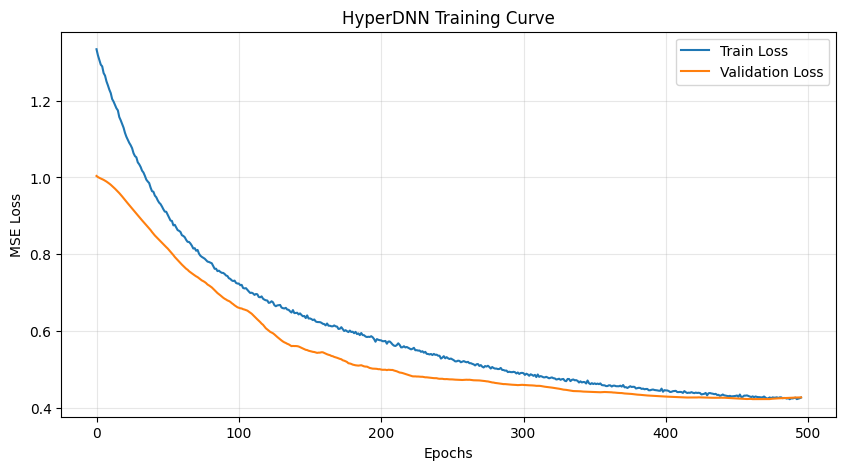


Extracting fused latent representations...

Latent representations:
  gene: torch.Size([205, 32])
  meth: torch.Size([205, 32])
  cnv: torch.Size([205, 32])

Fused latent shape: torch.Size([205, 96])


In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# ============================================================================
# HyperDNN: Hypernetwork-based Deep Neural Network for Multi-Omics Integration
# ============================================================================
# Uses LOW-RANK hypernetwork to efficiently generate modality-specific weights
# This avoids memory issues with high-dimensional omics data
# ============================================================================

class LowRankHyperNetwork(nn.Module):
    """
    Low-rank hypernetwork that generates weights efficiently using factorization.
    Instead of generating W directly (in_dim × out_dim), generates:
    W = U @ V where U is (in_dim × rank) and V is (rank × out_dim)
    This dramatically reduces memory for high-dimensional inputs.
    """
    def __init__(self, embedding_dim, hidden_dim, in_features, out_features, rank=16):
        super(LowRankHyperNetwork, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        
        # Shared backbone
        self.backbone = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Generate low-rank factors instead of full weight matrix
        # U: (in_features × rank), V: (rank × out_features)
        self.U_generator = nn.Linear(hidden_dim, in_features * rank)
        self.V_generator = nn.Linear(hidden_dim, rank * out_features)
        self.bias_generator = nn.Linear(hidden_dim, out_features)
        
        # Scaling factor
        self.scale = nn.Parameter(torch.ones(1) * 0.1)
    
    def forward(self, embedding):
        features = self.backbone(embedding)
        
        # Generate low-rank factors
        U = self.U_generator(features).view(self.in_features, self.rank)
        V = self.V_generator(features).view(self.rank, self.out_features)
        
        # Reconstruct weight matrix: W = U @ V (transposed for F.linear)
        weight = (U @ V).T * self.scale  # (out_features, in_features)
        bias = self.bias_generator(features)
        
        return weight, bias


class HyperEncoder(nn.Module):
    """
    Memory-efficient encoder using low-rank hypernetwork-generated weights.
    Only the first layer uses hypernetwork (most benefit for high-dim input).
    Subsequent layers use standard learnable weights.
    """
    def __init__(self, input_dim, hidden_dims, latent_dim, embedding_dim, 
                 hyper_hidden_dim=64, rank=16, dropout=0.3):
        super(HyperEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        
        # Hypernetwork only for the first (high-dimensional) layer
        self.hyper_layer = LowRankHyperNetwork(
            embedding_dim=embedding_dim,
            hidden_dim=hyper_hidden_dim,
            in_features=input_dim,
            out_features=hidden_dims[0],
            rank=rank
        )
        
        # Standard layers for the rest (much smaller, no need for hypernetwork)
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        prev_dim = hidden_dims[0]
        for hidden_dim in hidden_dims[1:]:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
            prev_dim = hidden_dim
        
        # Final layer to latent space
        self.final_layer = nn.Linear(prev_dim, latent_dim)
        self.first_bn = nn.BatchNorm1d(hidden_dims[0])
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, embedding):
        # First layer: use hypernetwork-generated weights
        weight, bias = self.hyper_layer(embedding)
        x = F.linear(x, weight, bias)
        x = self.first_bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Subsequent layers: standard weights
        for layer, bn in zip(self.layers, self.batch_norms):
            x = layer(x)
            x = bn(x)
            x = F.relu(x)
            x = self.dropout(x)
        
        # Final projection
        z = self.final_layer(x)
        return z


class HyperDecoder(nn.Module):
    """Standard decoder (low-dimensional, no hypernetwork needed)."""
    def __init__(self, latent_dim, hidden_dims, output_dim, dropout=0.3):
        super(HyperDecoder, self).__init__()
        
        layers = []
        prev_dim = latent_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.decoder = nn.Sequential(*layers)
    
    def forward(self, z):
        return self.decoder(z)


class HyperDNN(nn.Module):
    """
    Memory-Efficient HyperDNN for Multi-Omics Integration.
    
    Uses low-rank hypernetworks to generate modality-specific encoder weights
    based on learnable omics-type embeddings.
    """
    def __init__(self, input_dims, latent_dim=32, hyper_hidden_dim=64, 
                 embedding_dim=16, encoder_hidden_dims=[256, 64], 
                 rank=16, dropout=0.5):
        """
        Args:
            input_dims: Dict mapping omics names to input dimensions
            latent_dim: Dimension of the shared latent space
            hyper_hidden_dim: Hidden dimension of the hypernetwork
            embedding_dim: Dimension of omics-type embeddings
            encoder_hidden_dims: Hidden layer dimensions for encoders
            rank: Rank for low-rank weight approximation
            dropout: Dropout rate
        """
        super(HyperDNN, self).__init__()
        
        self.input_dims = input_dims
        self.latent_dim = latent_dim
        self.omics_names = list(input_dims.keys())
        self.num_omics = len(self.omics_names)
        self.embedding_dim = embedding_dim
        
        # Learnable omics-type embeddings
        self.omics_embeddings = nn.Embedding(self.num_omics, embedding_dim)
        
        # Create encoders and decoders for each omics type
        self.encoders = nn.ModuleDict()
        self.decoders = nn.ModuleDict()
        
        for name, input_dim in input_dims.items():
            # Encoder with hypernetwork for first layer
            self.encoders[name] = HyperEncoder(
                input_dim=input_dim,
                hidden_dims=encoder_hidden_dims,
                latent_dim=latent_dim,
                embedding_dim=embedding_dim,
                hyper_hidden_dim=hyper_hidden_dim,
                rank=rank,
                dropout=dropout
            )
            
            # Standard decoder
            self.decoders[name] = HyperDecoder(
                latent_dim=latent_dim,
                hidden_dims=list(reversed(encoder_hidden_dims)),
                output_dim=input_dim,
                dropout=dropout
            )
        
        # Register omics indices as buffer (stays on correct device)
        for i, name in enumerate(self.omics_names):
            self.register_buffer(f'omics_idx_{name}', torch.tensor(i))
    
    def get_omics_embedding(self, omics_name, device):
        """Get the embedding for an omics type on the correct device."""
        idx = getattr(self, f'omics_idx_{omics_name}')
        return self.omics_embeddings(idx)
    
    def encode(self, x, omics_name):
        """Encode input from a specific omics type."""
        embedding = self.get_omics_embedding(omics_name, x.device)
        z = self.encoders[omics_name](x, embedding)
        return z
    
    def decode(self, z, omics_name):
        """Decode latent representation to a specific omics type."""
        return self.decoders[omics_name](z)
    
    def forward(self, inputs):
        """
        Forward pass for all omics types.
        
        Args:
            inputs: Dict mapping omics names to input tensors
        
        Returns:
            latents: Dict of latent representations
            reconstructions: Dict of reconstructed outputs
        """
        latents = {}
        reconstructions = {}
        
        for name, x in inputs.items():
            z = self.encode(x, name)
            recon = self.decode(z, name)
            latents[name] = z
            reconstructions[name] = recon
        
        return latents, reconstructions
    
    def get_fused_latent(self, inputs, fusion='concat'):
        """Get fused latent representation from all omics."""
        latents, _ = self.forward(inputs)
        latent_list = [latents[name] for name in self.omics_names]
        
        if fusion == 'concat':
            return torch.cat(latent_list, dim=1)
        elif fusion == 'mean':
            return torch.stack(latent_list, dim=0).mean(dim=0)
        else:
            raise ValueError(f"Unknown fusion method: {fusion}")


# ------------------ Training with validation & early stopping ------------------
def train_hyperdnn(model, train_inputs, val_inputs, epochs=3000, patience=30, lr=1e-4):
    """Train HyperDNN with validation and early stopping."""
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        _, train_recons = model(train_inputs)
        
        train_loss = 0
        for name in train_inputs.keys():
            train_loss += criterion(train_recons[name], train_inputs[name])
        train_loss /= len(train_inputs)

        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            _, val_recons = model(val_inputs)
            val_loss = 0
            for name in val_inputs.keys():
                val_loss += criterion(val_recons[name], val_inputs[name])
            val_loss /= len(val_inputs)

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        scheduler.step(val_loss)

        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss.item():.4f} | Val: {val_loss.item():.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}!")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("HyperDNN Training Curve")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return model


# ------------------ Initialize and Train HyperDNN ------------------
print("="*70)
print("HYPERDNN: Low-Rank Hypernetwork for Multi-Omics Integration")
print("="*70)

# Get dimensions
gene_dim, meth_dim, cnv_dim = gene.shape[1], meth.shape[1], cnv.shape[1]
print(f"\nInput dimensions:")
print(f"  Gene Expression: {gene_dim}")
print(f"  Methylation: {meth_dim}")
print(f"  CNV: {cnv_dim}")
print(f"\nUsing device: {device}")

# Define input dimensions
input_dims = {
    'gene': gene_dim,
    'meth': meth_dim,
    'cnv': cnv_dim
}

# Create HyperDNN model with memory-efficient settings
hyperdnn = HyperDNN(
    input_dims=input_dims,
    latent_dim=32,
    hyper_hidden_dim=64,
    embedding_dim=16,
    encoder_hidden_dims=[256, 64],  # Smaller hidden dims
    rank=16,  # Low-rank approximation
    dropout=0.5
).to(device)

print(f"\nHyperDNN Architecture:")
print(f"  Latent dimension: 32")
print(f"  Hypernetwork hidden dim: 64")
print(f"  Omics embedding dim: 16")
print(f"  Encoder hidden layers: [128, 64]")
print(f"  Low-rank: 16")

# Count parameters
total_params = sum(p.numel() for p in hyperdnn.parameters())
trainable_params = sum(p.numel() for p in hyperdnn.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Verify model is on GPU
print(f"\nModel device check:")
for name, param in list(hyperdnn.named_parameters())[:2]:
    print(f"  {name}: {param.device}")

# Prepare train/val splits
n_samples = gene.shape[0]
n_train = int(0.8 * n_samples)

train_inputs = {
    'gene': gene[:n_train],
    'meth': meth[:n_train],
    'cnv': cnv[:n_train]
}

val_inputs = {
    'gene': gene[n_train:],
    'meth': meth[n_train:],
    'cnv': cnv[n_train:]
}

print(f"\nTraining samples: {n_train}")
print(f"Validation samples: {n_samples - n_train}")

# Train the model
print("\n" + "="*70)
print("Training HyperDNN...")
print("="*70)
hyperdnn = train_hyperdnn(hyperdnn, train_inputs, val_inputs, epochs=3000, patience=30)

# ------------------ Extract latents & fuse ------------------
print("\n" + "="*70)
print("Extracting fused latent representations...")
print("="*70)

hyperdnn.eval()
all_inputs = {
    'gene': gene,
    'meth': meth,
    'cnv': cnv
}

with torch.no_grad():
    z_fused = hyperdnn.get_fused_latent(all_inputs, fusion='concat')
    latents, _ = hyperdnn(all_inputs)

print(f"\nLatent representations:")
for name, z in latents.items():
    print(f"  {name}: {z.shape}")
print(f"\nFused latent shape: {z_fused.shape}")

HYPERDNN DIAGNOSTICS

1. Reconstruction Error Analysis
--------------------------------------------------


C:\Users\shini\AppData\Local\Temp\ipykernel_16064\1100923796.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_errors[name], label="Train", shade=True, ax=axes[idx])
C:\Users\shini\AppData\Local\Temp\ipykernel_16064\1100923796.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(val_errors[name], label="Validation", shade=True, ax=axes[idx])
C:\Users\shini\AppData\Local\Temp\ipykernel_16064\1100923796.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_errors[name], label="Train", shade=True, ax=axes[idx])
C:\Users\shini\AppData\Local\Temp\ipykernel_16064\1100923796.py:30: FutureWarning: 

`shade` is now 

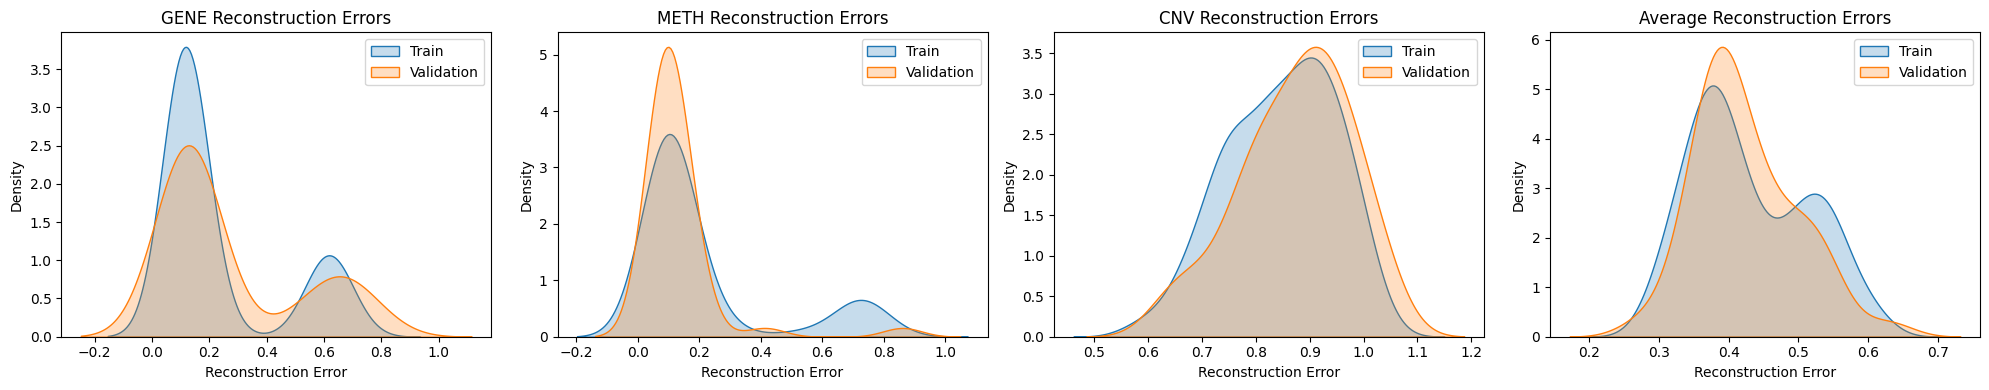

Reconstruction Error Summary:
------------------------------------------------------------
GENE:
  Train Median: 0.1214
  Val Median:   0.1314
METH:
  Train Median: 0.1068
  Val Median:   0.0945
CNV:
  Train Median: 0.8523
  Val Median:   0.8911

AVERAGE:
  Train Median: 0.4047
  Val Median:   0.4030

2. Omics Type Embeddings
--------------------------------------------------


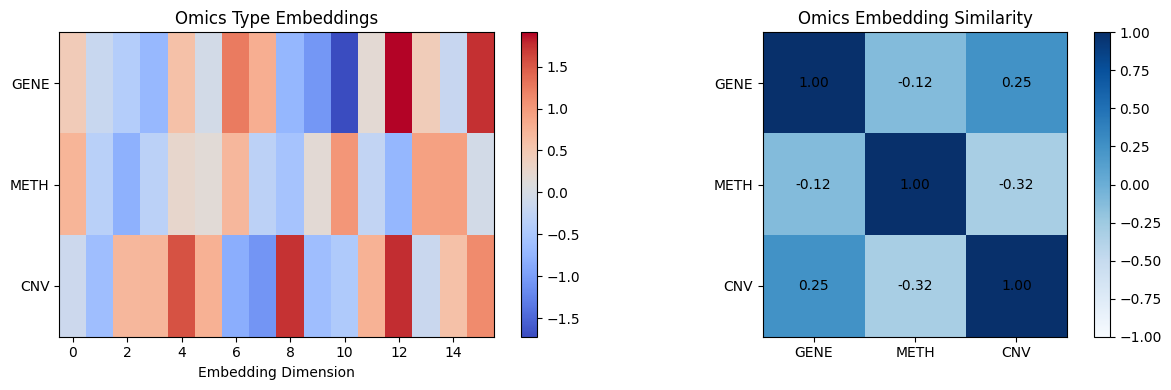


3. Latent Space Comparison
--------------------------------------------------
Latent Space Correlations (mean across dimensions):
--------------------------------------------------
  Gene-Meth: -0.010
  Gene-CNV: -0.073
  Meth-CNV: -0.006

4. Clustering Sanity Check
--------------------------------------------------
Silhouette Score on fused latents: 0.494


In [6]:
from sklearn.metrics import silhouette_score
import seaborn as sns

# ------------------ HyperDNN Diagnostics ------------------
def hyperdnn_reconstruction_error(model, train_inputs, val_inputs, device):
    """Compute and plot per-sample reconstruction errors for train/val."""
    
    def compute_errors(inputs):
        model.eval()
        with torch.no_grad():
            _, recons = model(inputs)
        
        errors = {}
        for name in inputs.keys():
            err = ((recons[name].cpu().numpy() - inputs[name].cpu().numpy())**2).mean(axis=1)
            errors[name] = err
        
        # Average across all omics
        avg_errors = np.mean([errors[name] for name in inputs.keys()], axis=0)
        return errors, avg_errors
    
    train_errors, train_avg = compute_errors(train_inputs)
    val_errors, val_avg = compute_errors(val_inputs)
    
    # Plot per-omics reconstruction errors
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    
    for idx, name in enumerate(train_inputs.keys()):
        sns.kdeplot(train_errors[name], label="Train", shade=True, ax=axes[idx])
        sns.kdeplot(val_errors[name], label="Validation", shade=True, ax=axes[idx])
        axes[idx].set_xlabel("Reconstruction Error")
        axes[idx].set_ylabel("Density")
        axes[idx].set_title(f"{name.upper()} Reconstruction Errors")
        axes[idx].legend()
    
    # Average errors
    sns.kdeplot(train_avg, label="Train", shade=True, ax=axes[3])
    sns.kdeplot(val_avg, label="Validation", shade=True, ax=axes[3])
    axes[3].set_xlabel("Reconstruction Error")
    axes[3].set_ylabel("Density")
    axes[3].set_title("Average Reconstruction Errors")
    axes[3].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Reconstruction Error Summary:")
    print("-" * 60)
    for name in train_inputs.keys():
        print(f"{name.upper()}:")
        print(f"  Train Median: {np.median(train_errors[name]):.4f}")
        print(f"  Val Median:   {np.median(val_errors[name]):.4f}")
    print(f"\nAVERAGE:")
    print(f"  Train Median: {np.median(train_avg):.4f}")
    print(f"  Val Median:   {np.median(val_avg):.4f}")
    
    return train_errors, val_errors


def visualize_omics_embeddings(model):
    """Visualize the learned omics-type embeddings."""
    model.eval()
    
    embeddings = model.omics_embeddings.weight.detach().cpu().numpy()
    omics_names = model.omics_names
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Heatmap of embeddings
    im = axes[0].imshow(embeddings, aspect='auto', cmap='coolwarm')
    axes[0].set_yticks(range(len(omics_names)))
    axes[0].set_yticklabels([name.upper() for name in omics_names])
    axes[0].set_xlabel("Embedding Dimension")
    axes[0].set_title("Omics Type Embeddings")
    plt.colorbar(im, ax=axes[0])
    
    # Pairwise cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    sim_matrix = cosine_similarity(embeddings)
    
    im2 = axes[1].imshow(sim_matrix, cmap='Blues', vmin=-1, vmax=1)
    axes[1].set_xticks(range(len(omics_names)))
    axes[1].set_yticks(range(len(omics_names)))
    axes[1].set_xticklabels([name.upper() for name in omics_names])
    axes[1].set_yticklabels([name.upper() for name in omics_names])
    axes[1].set_title("Omics Embedding Similarity")
    
    # Add text annotations
    for i in range(len(omics_names)):
        for j in range(len(omics_names)):
            axes[1].text(j, i, f'{sim_matrix[i, j]:.2f}', 
                        ha='center', va='center', fontsize=10)
    
    plt.colorbar(im2, ax=axes[1])
    plt.tight_layout()
    plt.show()


def compare_latent_spaces(model, inputs):
    """Compare latent spaces from different omics types."""
    model.eval()
    with torch.no_grad():
        latents, _ = model(inputs)
    
    # Get latent representations
    z_gene = latents['gene'].cpu().numpy()
    z_meth = latents['meth'].cpu().numpy()
    z_cnv = latents['cnv'].cpu().numpy()
    
    # Compute correlations between latent spaces
    from scipy.stats import pearsonr
    
    print("Latent Space Correlations (mean across dimensions):")
    print("-" * 50)
    
    corrs = {
        'Gene-Meth': np.mean([pearsonr(z_gene[:, i], z_meth[:, i])[0] for i in range(z_gene.shape[1])]),
        'Gene-CNV': np.mean([pearsonr(z_gene[:, i], z_cnv[:, i])[0] for i in range(z_gene.shape[1])]),
        'Meth-CNV': np.mean([pearsonr(z_meth[:, i], z_cnv[:, i])[0] for i in range(z_meth.shape[1])])
    }
    
    for pair, corr in corrs.items():
        print(f"  {pair}: {corr:.3f}")
    
    return corrs


# ------------------ Run Diagnostics ------------------
print("="*70)
print("HYPERDNN DIAGNOSTICS")
print("="*70)

# 1. Check reconstruction errors
print("\n1. Reconstruction Error Analysis")
print("-"*50)
train_inputs_diag = {'gene': gene[:n_train], 'meth': meth[:n_train], 'cnv': cnv[:n_train]}
val_inputs_diag = {'gene': gene[n_train:], 'meth': meth[n_train:], 'cnv': cnv[n_train:]}
train_errs, val_errs = hyperdnn_reconstruction_error(hyperdnn, train_inputs_diag, val_inputs_diag, device)

# 2. Visualize omics embeddings
print("\n2. Omics Type Embeddings")
print("-"*50)
visualize_omics_embeddings(hyperdnn)

# 3. Compare latent spaces
print("\n3. Latent Space Comparison")
print("-"*50)
all_inputs_diag = {'gene': gene, 'meth': meth, 'cnv': cnv}
corrs = compare_latent_spaces(hyperdnn, all_inputs_diag)

# 4. Clustering sanity check on fused latents
print("\n4. Clustering Sanity Check")
print("-"*50)
from sklearn.cluster import KMeans
z_np = z_fused.cpu().numpy()
kmeans = KMeans(n_clusters=3, random_state=42).fit(z_np)
score = silhouette_score(z_np, kmeans.labels_)
print(f"Silhouette Score on fused latents: {score:.3f}")

In [7]:
from sklearn.cluster import KMeans

# number of clusters: if unknown, try different values & compare
n_clusters = 3  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(z_fused.cpu().numpy())


In [8]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

X = z_fused.cpu().numpy()

sil_score = silhouette_score(X, cluster_labels)
ch_score  = calinski_harabasz_score(X, cluster_labels)
db_score  = davies_bouldin_score(X, cluster_labels)

print("Silhouette Score:", sil_score)              # higher is better ([-1, 1])
print("Calinski-Harabasz Score:", ch_score)        # higher is better
print("Davies-Bouldin Score:", db_score)           # lower is better



Silhouette Score: 0.49430832266807556
Calinski-Harabasz Score: 102.5282974243164
Davies-Bouldin Score: 0.8499685375424805


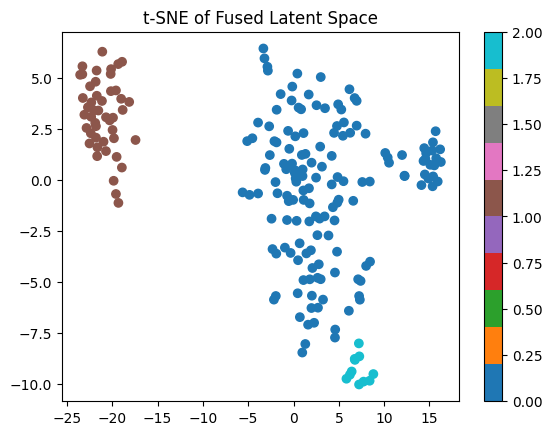

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z_fused.cpu().numpy())

plt.scatter(z_2d[:,0], z_2d[:,1], c=cluster_labels, cmap="tab10")
plt.colorbar()
plt.title("t-SNE of Fused Latent Space")
plt.show()


In [10]:
# Load subtype labels
labels_df = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

# Align labels with our data
common_samples = gene_df.index.intersection(labels_df.index)
print(f"Samples with labels: {len(common_samples)}")

# Filter data and labels to common samples
labels = labels_df.loc[common_samples].values.ravel()
z_fused_labeled = z_fused.cpu().numpy()

# If data was already aligned, we might need to reindex
if len(common_samples) < len(gene_df):
    # Refilter if needed
    gene_idx = gene_df.index.get_indexer(common_samples)
    z_fused_labeled = z_fused.cpu().numpy()[gene_idx]

print(f"Final data shape: {z_fused_labeled.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Unique classes: {np.unique(labels)}")
print(f"Class distribution: {np.bincount(labels.astype(int))}")

Samples with labels: 205
Final data shape: (205, 96)
Labels shape: (205,)
Unique classes: [0 1 2 3]
Class distribution: [53 22 96 34]


Embeddings shape: (205, 96)
Labels shape: (205,)
Unique labels: [0 1 2 3]
Computing PCA...
Computing t-SNE...


C:\Users\shini\AppData\Local\Temp\ipykernel_16064\609242418.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 2].set_xticklabels(omic_contributions.keys(), rotation=45)


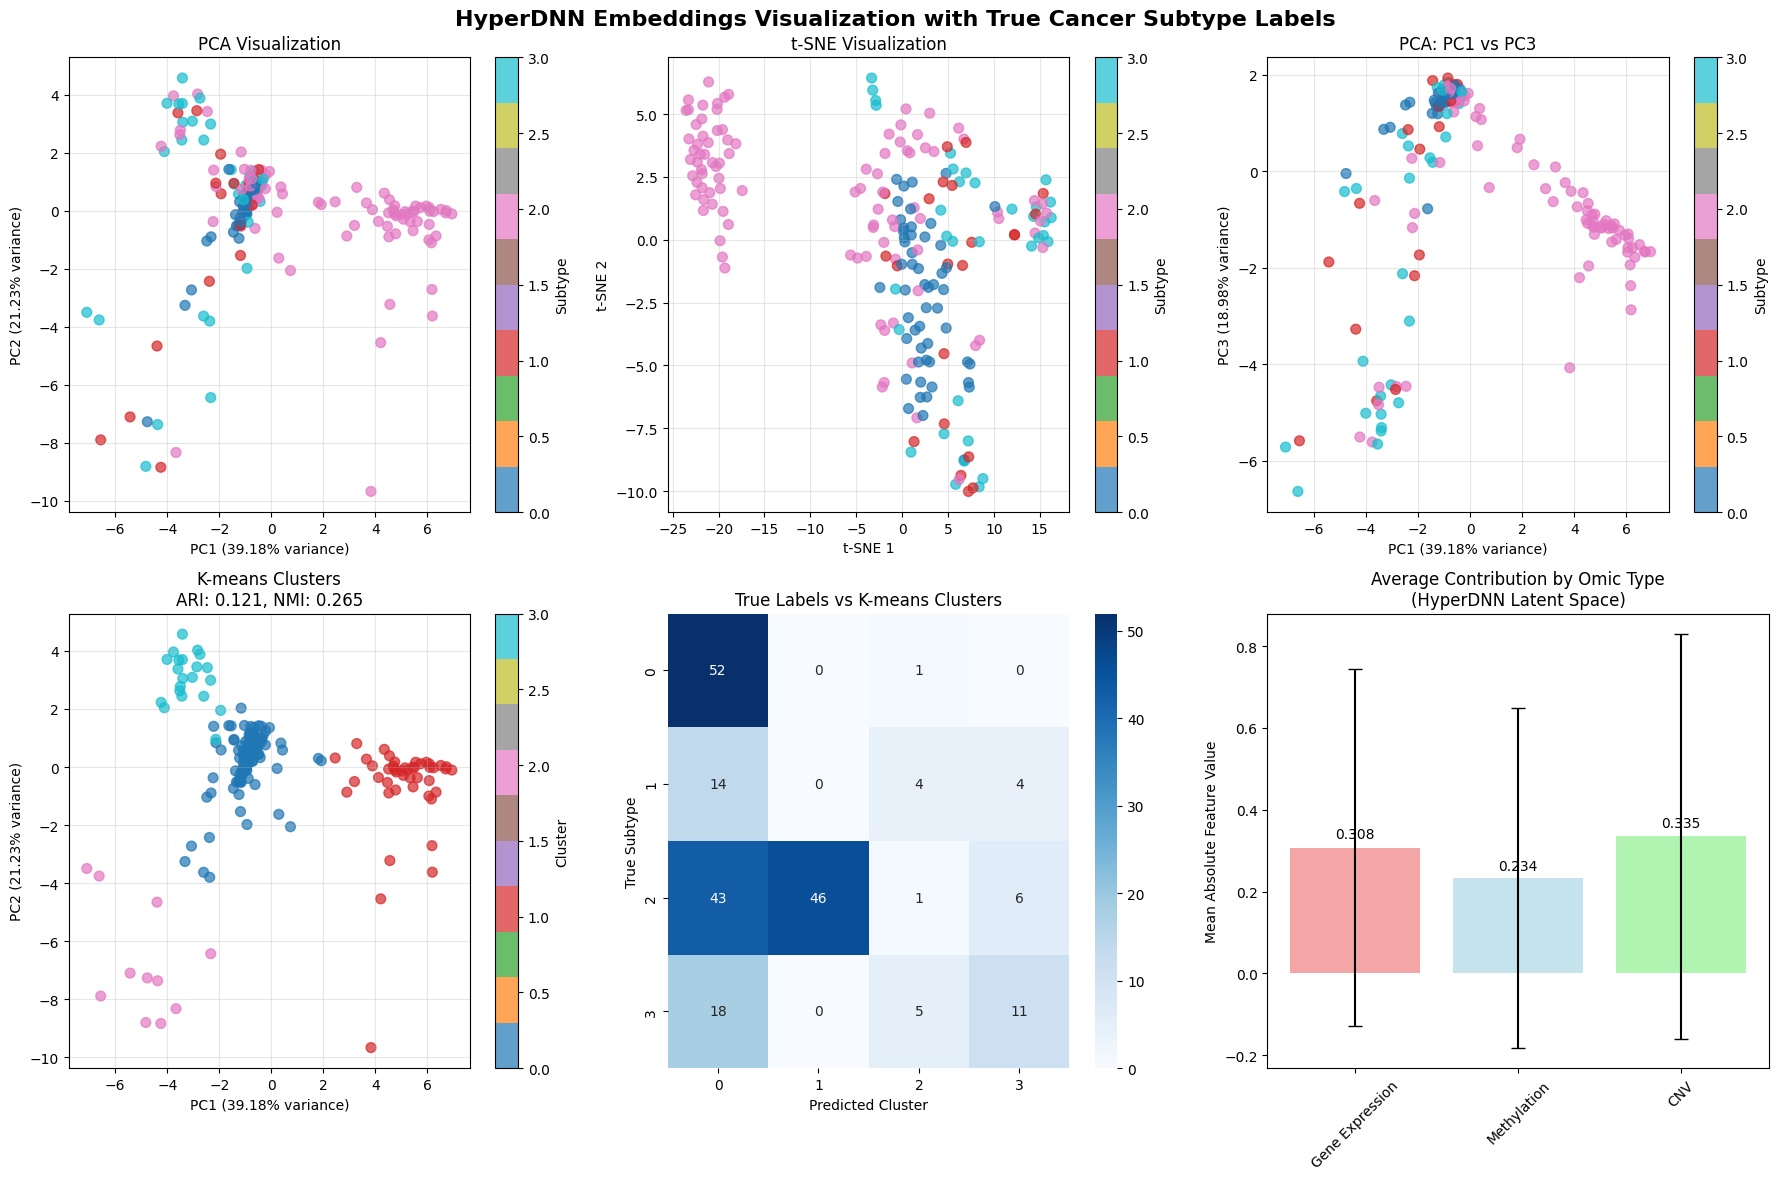

In [11]:
# Visualize HyperDNN embeddings with actual labels
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Get the fused embeddings and labels
embeddings = z_fused_labeled
true_labels = labels

print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {true_labels.shape}")
print(f"Unique labels: {np.unique(true_labels)}")

# Create label names (assuming 0,1,2,3 are different cancer subtypes)
label_names = {0: 'Subtype 0', 1: 'Subtype 1', 2: 'Subtype 2', 3: 'Subtype 3'}
colored_labels = [label_names.get(int(label), f'Subtype {int(label)}') for label in true_labels]

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('HyperDNN Embeddings Visualization with True Cancer Subtype Labels', fontsize=16, fontweight='bold')

# 1. PCA 2D visualization
print("Computing PCA...")
pca_2d = PCA(n_components=2, random_state=42)
embeddings_pca_2d = pca_2d.fit_transform(embeddings)

scatter1 = axes[0, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[0, 0].set_title('PCA Visualization')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Subtype')

# 2. t-SNE 2D visualization
print("Computing t-SNE...")
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne_2d = tsne_2d.fit_transform(embeddings)

scatter2 = axes[0, 1].scatter(embeddings_tsne_2d[:, 0], embeddings_tsne_2d[:, 1], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')
axes[0, 1].set_title('t-SNE Visualization')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Subtype')

# 3. PCA 3D to 2D projections (PC1 vs PC3)
pca_3d = PCA(n_components=3, random_state=42)
embeddings_pca_3d = pca_3d.fit_transform(embeddings)

scatter3 = axes[0, 2].scatter(embeddings_pca_3d[:, 0], embeddings_pca_3d[:, 2], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 2].set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 2].set_ylabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)')
axes[0, 2].set_title('PCA: PC1 vs PC3')
axes[0, 2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[0, 2], label='Subtype')

# 4. Cluster analysis comparison
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Perform K-means clustering
n_clusters = len(np.unique(true_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters = kmeans.fit_predict(embeddings)

# Calculate clustering metrics
ari_score = adjusted_rand_score(true_labels, predicted_clusters)
nmi_score = normalized_mutual_info_score(true_labels, predicted_clusters)

scatter4 = axes[1, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                             c=predicted_clusters, cmap='tab10', alpha=0.7, s=50)
axes[1, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[1, 0].set_title(f'K-means Clusters\nARI: {ari_score:.3f}, NMI: {nmi_score:.3f}')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1, 0], label='Cluster')

# 5. Side-by-side comparison: True vs Predicted
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_clusters)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted Cluster')
axes[1, 1].set_ylabel('True Subtype')
axes[1, 1].set_title('True Labels vs K-means Clusters')

# 6. Per-omics latent contribution analysis
# For HyperDNN with latent_dim=32 per omics, fused = 96 total (32*3)
latent_dim = 32
omic_contributions = {
    'Gene Expression': embeddings[:, :latent_dim],
    'Methylation': embeddings[:, latent_dim:2*latent_dim],
    'CNV': embeddings[:, 2*latent_dim:3*latent_dim]
}

omic_means = [np.mean(np.abs(contrib)) for contrib in omic_contributions.values()]
omic_stds = [np.std(np.abs(contrib)) for contrib in omic_contributions.values()]

bars = axes[1, 2].bar(omic_contributions.keys(), omic_means, 
                      yerr=omic_stds, capsize=5, alpha=0.7, 
                      color=['lightcoral', 'lightblue', 'lightgreen'])
axes[1, 2].set_ylabel('Mean Absolute Feature Value')
axes[1, 2].set_title('Average Contribution by Omic Type\n(HyperDNN Latent Space)')
axes[1, 2].set_xticklabels(omic_contributions.keys(), rotation=45)

# Add value labels on bars
for bar, mean_val in zip(bars, omic_means):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.05,
                    f'{mean_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
# ====================================================================
# CENTRALIZED DATA SPLITTING FOR ALL ML CLASSIFIERS
# ====================================================================
# This cell creates train/test splits used by all models
# Each disease subtype is split 80/20 independently, then merged
# to ensure consistent comparison across different classifiers
# ====================================================================

from sklearn.model_selection import train_test_split
import numpy as np

# Prepare features and labels
X = z_fused_labeled  # Fused latent features
y = labels  # Cancer subtype labels

print("="*70)
print("STRATIFIED DATA SPLITTING BY DISEASE SUBTYPE")
print("="*70)
print(f"\n📊 Total samples: {len(X)}")
print(f"\n🔬 Disease subtype distribution:")

# Get unique disease subtypes
unique_subtypes = np.unique(y)
for subtype_idx in unique_subtypes:
    count = np.sum(y == subtype_idx)
    print(f"   - Subtype {subtype_idx}: {count} samples")

# ====================================================================
# Split each disease subtype 80/20, then merge
# ====================================================================
print(f"\n{'='*70}")
print("🔹 Train/Test Split - Stratified by Disease:")
print(f"{'='*70}")

X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for subtype_idx in unique_subtypes:
    # Get samples for this subtype
    subtype_mask = (y == subtype_idx)
    X_subtype = X[subtype_mask]
    y_subtype = y[subtype_mask]
    
    # Split this subtype 80/20
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
        X_subtype, y_subtype, test_size=0.2, random_state=42
    )
    
    X_train_list.append(X_train_sub)
    X_test_list.append(X_test_sub)
    y_train_list.append(y_train_sub)
    y_test_list.append(y_test_sub)
    
    print(f"   Subtype {subtype_idx}:")
    print(f"      Train: {len(X_train_sub)} samples ({len(X_train_sub)/len(X_subtype)*100:.1f}%)")
    print(f"      Test:  {len(X_test_sub)} samples ({len(X_test_sub)/len(X_subtype)*100:.1f}%)")

# Merge all subtypes
X_train = np.vstack(X_train_list)
X_test = np.vstack(X_test_list)
y_train = np.concatenate(y_train_list)
y_test = np.concatenate(y_test_list)

print(f"\n📦 Merged splits:")
print(f"   - Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   - Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify distribution in train and test
print(f"\n📊 Disease distribution in splits:")
for subtype_idx in unique_subtypes:
    train_count = np.sum(y_train == subtype_idx)
    test_count = np.sum(y_test == subtype_idx)
    print(f"   Subtype {subtype_idx}:")
    print(f"      Train: {train_count} ({train_count/len(y_train)*100:.1f}%)")
    print(f"      Test:  {test_count} ({test_count/len(y_test)*100:.1f}%)")

print(f"\n✅ Data splits created successfully with stratification by disease!")
print(f"   - All ML classifiers will use: X_train, X_test, y_train, y_test")
print("="*70)

STRATIFIED DATA SPLITTING BY DISEASE SUBTYPE

📊 Total samples: 205

🔬 Disease subtype distribution:
   - Subtype 0: 53 samples
   - Subtype 1: 22 samples
   - Subtype 2: 96 samples
   - Subtype 3: 34 samples

🔹 Train/Test Split - Stratified by Disease:
   Subtype 0:
      Train: 42 samples (79.2%)
      Test:  11 samples (20.8%)
   Subtype 1:
      Train: 17 samples (77.3%)
      Test:  5 samples (22.7%)
   Subtype 2:
      Train: 76 samples (79.2%)
      Test:  20 samples (20.8%)
   Subtype 3:
      Train: 27 samples (79.4%)
      Test:  7 samples (20.6%)

📦 Merged splits:
   - Training set: 162 samples (79.0%)
   - Test set: 43 samples (21.0%)

📊 Disease distribution in splits:
   Subtype 0:
      Train: 42 (25.9%)
      Test:  11 (25.6%)
   Subtype 1:
      Train: 17 (10.5%)
      Test:  5 (11.6%)
   Subtype 2:
      Train: 76 (46.9%)
      Test:  20 (46.5%)
   Subtype 3:
      Train: 27 (16.7%)
      Test:  7 (16.3%)

✅ Data splits created successfully with stratification by diseas

In [13]:
# ====================================================================
# Using MLClassifier module for ML Classification
# X_train, X_test, y_train, y_test are already created from above
# ====================================================================

from ml_classifier import MLClassifier, train_classifiers

print(f"✅ Using centralized data splits:")
print(f"   Training set size: {X_train.shape[0]}")
print(f"   Test set size: {X_test.shape[0]}")
print(f"   Training class distribution: {np.bincount(y_train.astype(int))}")
print(f"   Test class distribution: {np.bincount(y_test.astype(int))}")

✅ Using centralized data splits:
   Training set size: 162
   Test set size: 43
   Training class distribution: [42 17 76 27]
   Test class distribution: [11  5 20  7]


In [14]:
# Train and evaluate all ML classifiers using MLClassifier module
ml_classifier = MLClassifier(random_state=42, include_xgboost=True)
results = ml_classifier.train_and_evaluate(X_train, X_test, y_train, y_test, verbose=True)

# Print results summary
ml_classifier.print_results()

# Get results dataframe for later use
results_df = ml_classifier.get_results_dataframe()

# Get the classifiers dictionary for compatibility with later cells
classifiers = ml_classifier.classifiers

Training and evaluating classifiers...
  Training Random Forest...
  Training Gradient Boosting...
  Training SVM (RBF)...
  Training SVM (Linear)...
  Training Logistic Regression...
  Training K-Nearest Neighbors...
  Training Naive Bayes...
  Training Decision Tree...
  Training XGBoost...


f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:16:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Trained and evaluated 9 classifiers

ML CLASSIFIER RESULTS
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
Logistic Regression  0.697674           0.724790           0.697674        0.621916        0.697674    0.631274    0.697674 0.858156
       SVM (Linear)  0.674419           0.602731           0.674419        0.599188        0.674419    0.594034    0.674419 0.852071
      Random Forest  0.651163           0.485998           0.651163        0.534903        0.651163    0.499444    0.651163 0.856495
  Gradient Boosting  0.627907           0.484375           0.627907        0.512175        0.627907    0.487510    0.627907 0.813610
        Naive Bayes  0.627907           0.480392           0.627907        0.532630        0.627907    0.480804    0.627907 0.790064
            XGBoost  0.627907           0.479612           0.627907        0.488961        0.627907    0.476982    0.627907 0.841219
        

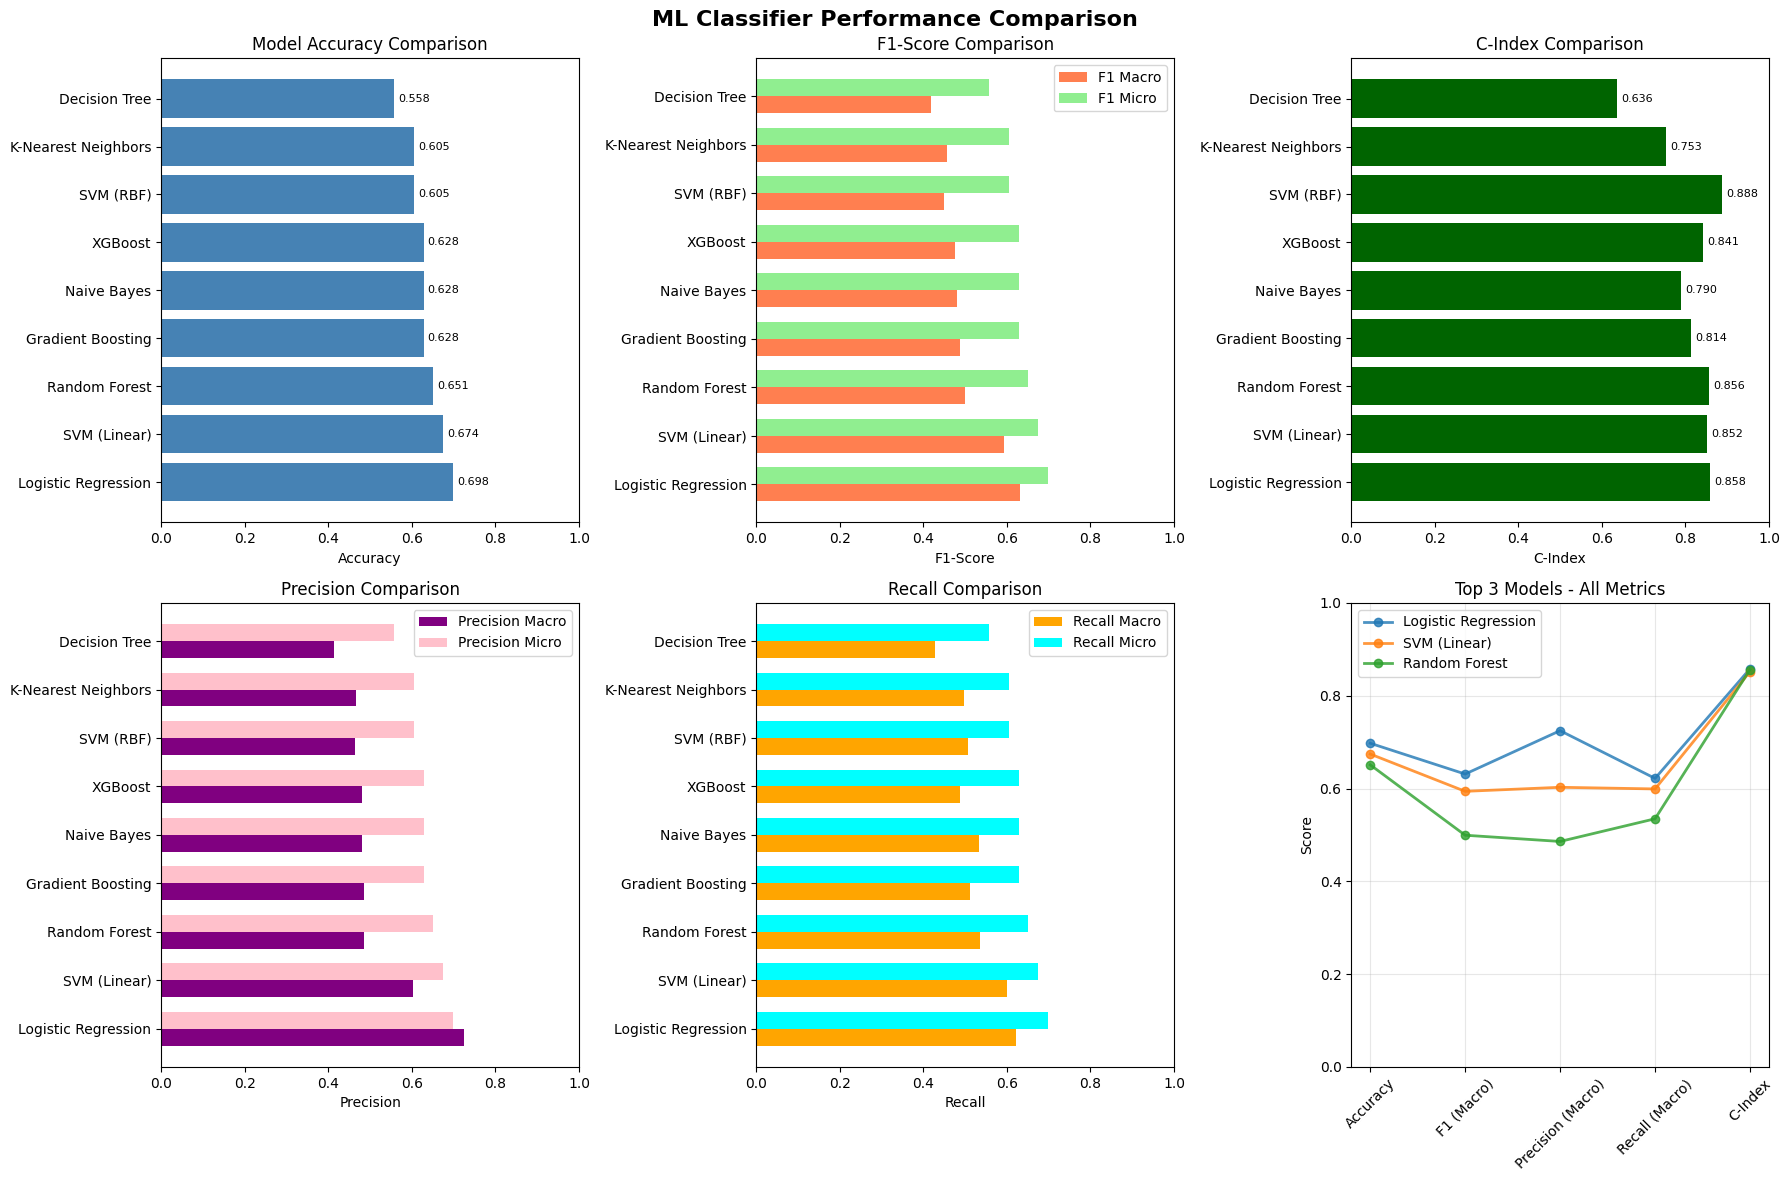

In [15]:
# Visualize ML classification results using MLClassifier module
ml_classifier.plot_results(figsize=(18, 12))

In [16]:
# Cell 20: Prevent running cells below (choose one of the actions below)

# Option A: Quick abort (stops kernel/run-all)
# import sys
# sys.exit("Stopping execution here; cells below will not run.")

# Option B: Reusable stop flag + pre-run hook (preferred)
# STOP_FOLLOWING_CELLS = True

# def _stop_on_flag(*args, **kwargs):
#     if globals().get("STOP_FOLLOWING_CELLS"):
#         print("STOP_FOLLOWING_CELLS=True -- aborting further execution.")
#         raise SystemExit("Stopped by STOP_FOLLOWING_CELLS")

# get_ipython().events.register('pre_run_cell', _stop_on_flag)

# To resume running later:
# STOP_FOLLOWING_CELLS = False
# get_ipython().events.unregister('pre_run_cell', _stop_on_flag)


DETAILED REPORT FOR MODEL: Random Forest

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.6429    0.8182    0.7200        11
           1     0.0000    0.0000    0.0000         5
           2     0.9375    0.7500    0.8333        20
           3     0.3636    0.5714    0.4444         7

    accuracy                         0.6512        43
   macro avg     0.4860    0.5349    0.4994        43
weighted avg     0.6597    0.6512    0.6441        43



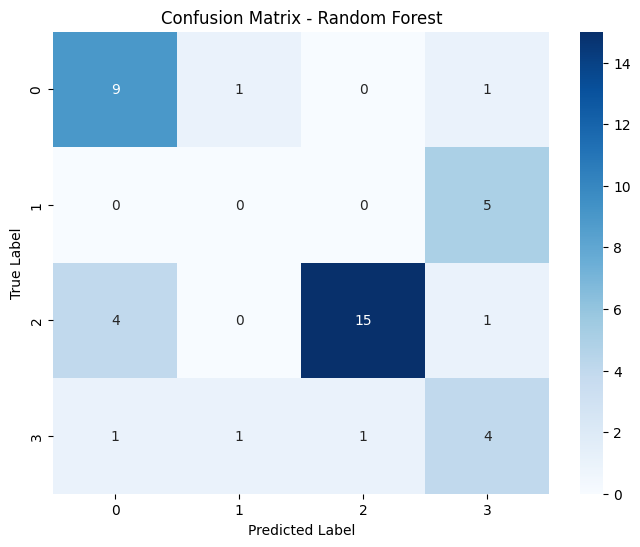


Confusion Matrix:
[[ 9  1  0  1]
 [ 0  0  0  5]
 [ 4  0 15  1]
 [ 1  1  1  4]]

DETAILED REPORT FOR MODEL: Gradient Boosting

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.6667    0.7273    0.6957        11
           1     0.0000    0.0000    0.0000         5
           2     0.9375    0.7500    0.8333        20
           3     0.3333    0.5714    0.4211         7

    accuracy                         0.6279        43
   macro avg     0.4844    0.5122    0.4875        43
weighted avg     0.6609    0.6279    0.6341        43



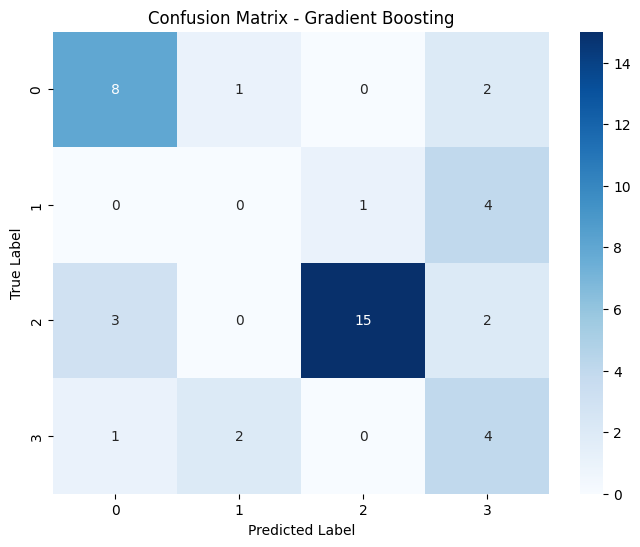


Confusion Matrix:
[[ 8  1  0  2]
 [ 0  0  1  4]
 [ 3  0 15  2]
 [ 1  2  0  4]]

DETAILED REPORT FOR MODEL: SVM (RBF)

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.4783    1.0000    0.6471        11
           1     0.0000    0.0000    0.0000         5
           2     1.0000    0.6000    0.7500        20
           3     0.3750    0.4286    0.4000         7

    accuracy                         0.6047        43
   macro avg     0.4633    0.5071    0.4493        43
weighted avg     0.6485    0.6047    0.5795        43



f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

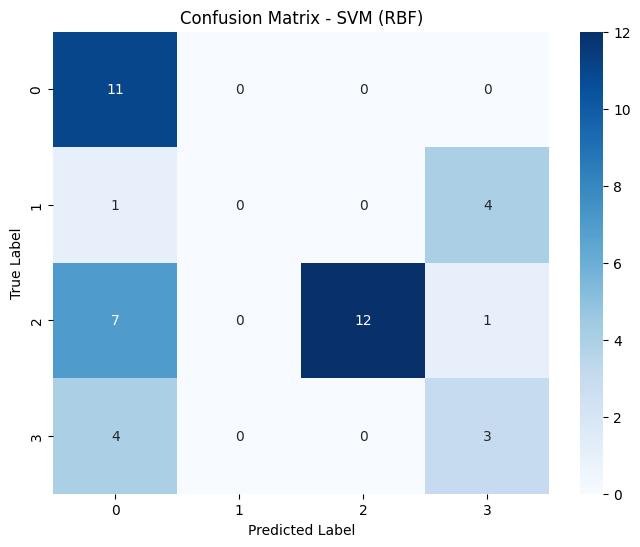


Confusion Matrix:
[[11  0  0  0]
 [ 1  0  0  4]
 [ 7  0 12  1]
 [ 4  0  0  3]]

DETAILED REPORT FOR MODEL: SVM (Linear)

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.6000    0.8182    0.6923        11
           1     0.5000    0.4000    0.4444         5
           2     0.8824    0.7500    0.8108        20
           3     0.4286    0.4286    0.4286         7

    accuracy                         0.6744        43
   macro avg     0.6027    0.5992    0.5940        43
weighted avg     0.6918    0.6744    0.6757        43



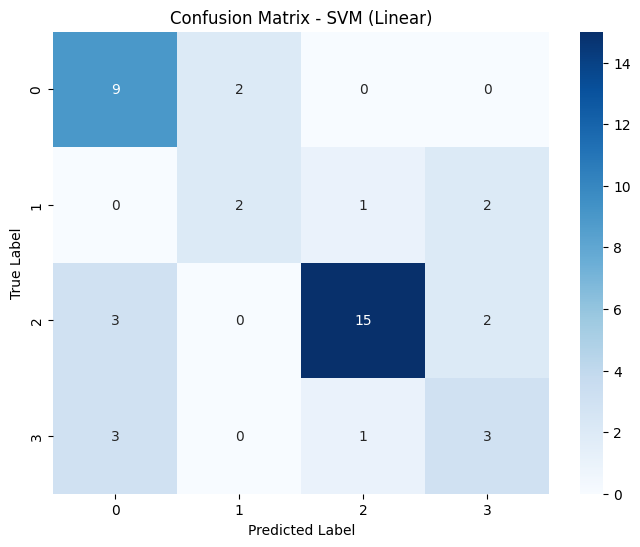


Confusion Matrix:
[[ 9  2  0  0]
 [ 0  2  1  2]
 [ 3  0 15  2]
 [ 3  0  1  3]]

DETAILED REPORT FOR MODEL: Logistic Regression

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5882    0.9091    0.7143        11
           1     1.0000    0.4000    0.5714         5
           2     0.8824    0.7500    0.8108        20
           3     0.4286    0.4286    0.4286         7

    accuracy                         0.6977        43
   macro avg     0.7248    0.6219    0.6313        43
weighted avg     0.7469    0.6977    0.6961        43



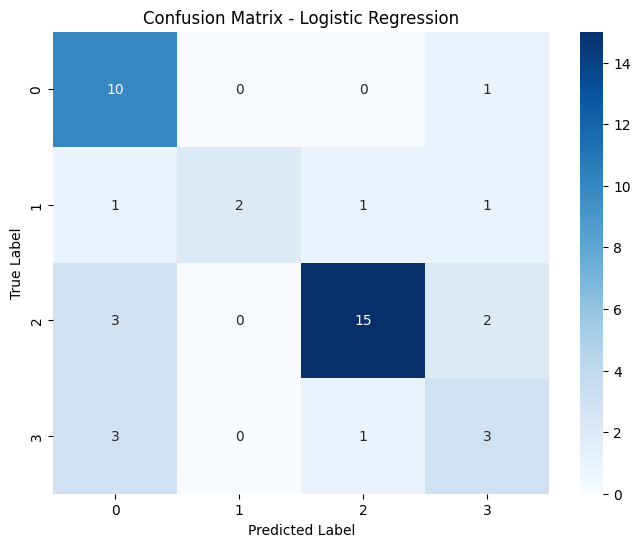


Confusion Matrix:
[[10  0  0  1]
 [ 1  2  1  1]
 [ 3  0 15  2]
 [ 3  0  1  3]]

DETAILED REPORT FOR MODEL: K-Nearest Neighbors

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.4545    0.9091    0.6061        11
           1     0.0000    0.0000    0.0000         5
           2     0.8125    0.6500    0.7222        20
           3     0.6000    0.4286    0.5000         7

    accuracy                         0.6047        43
   macro avg     0.4668    0.4969    0.4571        43
weighted avg     0.5919    0.6047    0.5724        43



f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

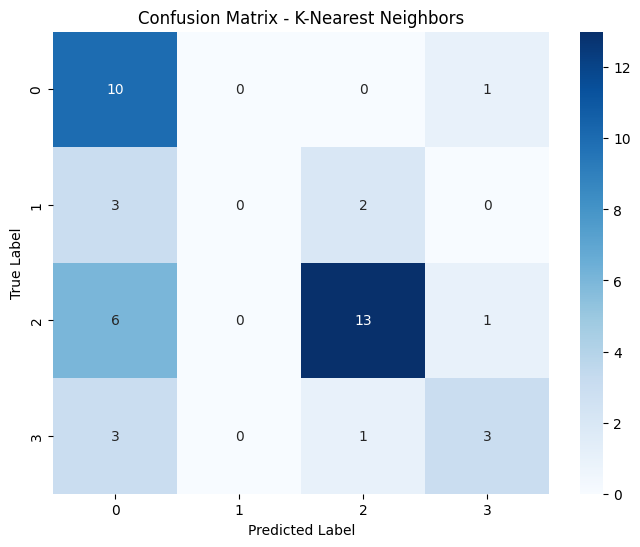


Confusion Matrix:
[[10  0  0  1]
 [ 3  0  2  0]
 [ 6  0 13  1]
 [ 3  0  1  3]]

DETAILED REPORT FOR MODEL: Naive Bayes

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5882    0.9091    0.7143        11
           1     0.0000    0.0000    0.0000         5
           2     1.0000    0.6500    0.7879        20
           3     0.3333    0.5714    0.4211         7

    accuracy                         0.6279        43
   macro avg     0.4804    0.5326    0.4808        43
weighted avg     0.6699    0.6279    0.6177        43



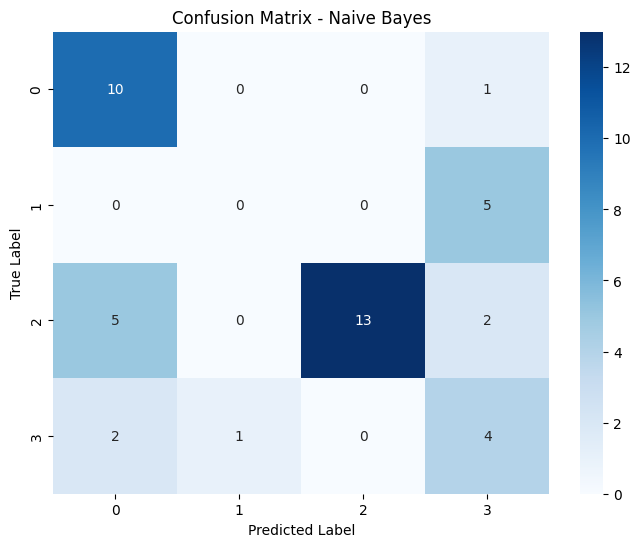


Confusion Matrix:
[[10  0  0  1]
 [ 0  0  0  5]
 [ 5  0 13  2]
 [ 2  1  0  4]]

DETAILED REPORT FOR MODEL: Decision Tree

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7273    0.7273    0.7273        11
           1     0.0000    0.0000    0.0000         5
           2     0.7000    0.7000    0.7000        20
           3     0.2222    0.2857    0.2500         7

    accuracy                         0.5581        43
   macro avg     0.4124    0.4282    0.4193        43
weighted avg     0.5478    0.5581    0.5523        43



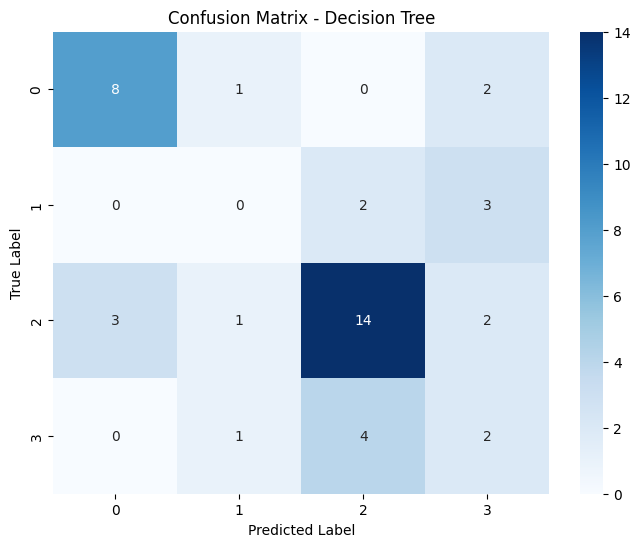


Confusion Matrix:
[[ 8  1  0  2]
 [ 0  0  2  3]
 [ 3  1 14  2]
 [ 0  1  4  2]]

DETAILED REPORT FOR MODEL: XGBoost

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7273    0.7273    0.7273        11
           1     0.0000    0.0000    0.0000         5
           2     0.9412    0.8000    0.8649        20
           3     0.2500    0.4286    0.3158         7

    accuracy                         0.6279        43
   macro avg     0.4796    0.4890    0.4770        43
weighted avg     0.6645    0.6279    0.6397        43



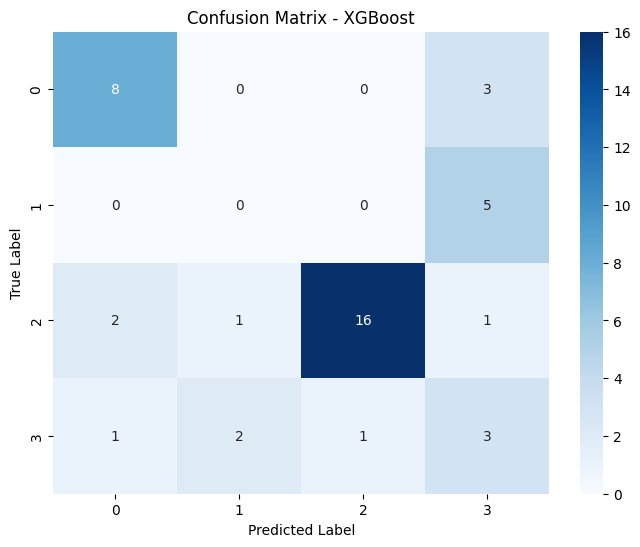


Confusion Matrix:
[[ 8  0  0  3]
 [ 0  0  0  5]
 [ 2  1 16  1]
 [ 1  2  1  3]]


In [17]:
# Detailed classification reports and confusion matrices
import seaborn as sns
from sklearn.metrics import classification_report

for name in classifiers.keys():
    print(f"\n{'='*80}")
    print(f"DETAILED REPORT FOR MODEL: {name}")
    print(f"{'='*80}\n")
    
    print("Classification Report (per-class metrics):")
    print("-"*80)
    print(ml_classifier.get_classification_report(name))
    
    cm = ml_classifier.get_confusion_matrix(name)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    
    print(f"\nConfusion Matrix:")
    print(cm)

In [18]:
# Cross-validation using MLClassifier module
# Get top 3 model names by accuracy
top_3_models = results_df.head(3)['Model'].tolist()

cv_results = ml_classifier.cross_validate(
    X=z_fused_labeled, 
    y=labels, 
    cv=5, 
    model_names=top_3_models
)


Performing 5-Fold Cross-Validation...
--------------------------------------------------------------------------------


f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy

Logistic Regression:
  Accuracy: 0.6976 (+/- 0.0119)
  F1-Macro: 0.5805 (+/- 0.0155)
  C-Index:  0.8739 (+/- 0.0170)
SVM (Linear):
  Accuracy: 0.6634 (+/- 0.0358)
  F1-Macro: 0.4961 (+/- 0.0560)
  C-Index:  0.8508 (+/- 0.0277)
Random Forest:
  Accuracy: 0.7024 (+/- 0.0239)
  F1-Macro: 0.5710 (+/- 0.0709)
  C-Index:  0.8793 (+/- 0.0131)


# Survival Analysis Visualization

Now let's perform survival analysis to understand the relationship between cancer subtypes (predicted by our HyperDNN model) and patient outcomes.

In [19]:
# Load and prepare survival data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.plotting import plot_lifetimes
import warnings
warnings.filterwarnings('ignore')

# Load survival data
survival_df = pd.read_csv("../RawData/TCGA-SARC.survival.tsv", sep='\t')
print(f"Survival data shape: {survival_df.shape}")
print(f"Survival data columns: {survival_df.columns.tolist()}")
print(f"Sample survival data:")
print(survival_df.head())

# Check for missing values
print(f"\nMissing values:")
print(survival_df.isnull().sum())

# Basic statistics
print(f"\nSurvival statistics:")
print(f"OS.time range: {survival_df['OS.time'].min():.1f} - {survival_df['OS.time'].max():.1f} months")
print(f"Event rate (deaths): {survival_df['OS'].mean():.3f} ({survival_df['OS'].sum()} out of {len(survival_df)})")
print(f"Median follow-up time: {survival_df['OS.time'].median():.1f} months")

Survival data shape: (269, 4)
Survival data columns: ['sample', 'OS.time', 'OS', '_PATIENT']
Sample survival data:
             sample  OS.time  OS      _PATIENT
0  TCGA-MB-A5YA-01A     15.0   0  TCGA-MB-A5YA
1  TCGA-3R-A8YX-01A     17.0   1  TCGA-3R-A8YX
2  TCGA-HS-A5N8-01A     22.0   1  TCGA-HS-A5N8
3  TCGA-RN-A68Q-01A     22.0   0  TCGA-RN-A68Q
4  TCGA-X6-A7W8-01A     24.0   1  TCGA-X6-A7W8

Missing values:
sample      0
OS.time     0
OS          0
_PATIENT    0
dtype: int64

Survival statistics:
OS.time range: 15.0 - 5723.0 months
Event rate (deaths): 0.379 (102 out of 269)
Median follow-up time: 959.0 months


In [20]:
# Get predictions from the best model for survival analysis
best_model_name = results_df.iloc[0]['Model']
best_clf = classifiers[best_model_name]

# Get predictions for all samples (not just test set)
all_predictions = best_clf.predict(z_fused_labeled)
all_prediction_probs = best_clf.predict_proba(z_fused_labeled)

# Create a mapping of sample indices to predictions
# Assuming gene_df.index contains the sample IDs that match survival data
sample_ids = gene_df.index.tolist()
predictions_df = pd.DataFrame({
    'sample': sample_ids,
    'predicted_subtype': all_predictions,
    'subtype_0_prob': all_prediction_probs[:, 0],
    'subtype_1_prob': all_prediction_probs[:, 1] if all_prediction_probs.shape[1] > 1 else 0,
    'subtype_2_prob': all_prediction_probs[:, 2] if all_prediction_probs.shape[1] > 2 else 0,
    'subtype_3_prob': all_prediction_probs[:, 3] if all_prediction_probs.shape[1] > 3 else 0,
    'max_prob': np.max(all_prediction_probs, axis=1)  # Confidence score
})

print(f"Predictions shape: {predictions_df.shape}")
print(f"Predicted subtypes distribution:")
print(predictions_df['predicted_subtype'].value_counts().sort_index())
print(f"\nSample predictions:")
print(predictions_df.head())

Predictions shape: (205, 7)
Predicted subtypes distribution:
predicted_subtype
0    76
1     8
2    83
3    38
Name: count, dtype: int64

Sample predictions:
             sample  predicted_subtype  subtype_0_prob  subtype_1_prob  \
0  TCGA-DX-A48J-01A                  2        0.031487        0.003237   
1  TCGA-QQ-A5VA-01A                  0        0.606319        0.104011   
2  TCGA-DX-AB36-01A                  0        0.683277        0.075775   
3  TCGA-Z4-AAPG-01A                  3        0.002773        0.019198   
4  TCGA-DX-A48N-01A                  0        0.654008        0.111270   

   subtype_2_prob  subtype_3_prob  max_prob  
0        0.963335        0.001941  0.963335  
1        0.227080        0.062590  0.606319  
2        0.158863        0.082085  0.683277  
3        0.306089        0.671940  0.671940  
4        0.159882        0.074840  0.654008  


In [21]:
# Merge survival data with predictions
# First, let's align the sample names properly
survival_df['sample_clean'] = survival_df['sample'].str.replace('-01A', '', regex=False)
predictions_df['sample_clean'] = predictions_df['sample'].str.replace('-01A', '', regex=False)

# Merge on cleaned sample names
survival_analysis_df = pd.merge(
    survival_df, 
    predictions_df, 
    left_on='sample_clean', 
    right_on='sample_clean', 
    how='inner'
)

print(f"Merged data shape: {survival_analysis_df.shape}")
print(f"Successfully matched {len(survival_analysis_df)} samples")

if len(survival_analysis_df) == 0:
    print("No matching samples found. Trying direct merge...")
    # Try direct merge without cleaning
    survival_analysis_df = pd.merge(
        survival_df, 
        predictions_df, 
        left_on='sample', 
        right_on='sample', 
        how='inner'
    )
    print(f"Direct merge result: {survival_analysis_df.shape}")

if len(survival_analysis_df) > 0:
    # Clean up column names - pandas creates sample_x and sample_y during merge
    if 'sample_x' in survival_analysis_df.columns:
        survival_analysis_df = survival_analysis_df.rename(columns={'sample_x': 'sample'})
        if 'sample_y' in survival_analysis_df.columns:
            survival_analysis_df = survival_analysis_df.drop(columns=['sample_y'])
    
    print(f"\nSubtype distribution in survival cohort:")
    print(survival_analysis_df['predicted_subtype'].value_counts().sort_index())
    print(f"\nSample of merged data:")
    print(survival_analysis_df[['sample', 'OS.time', 'OS', 'predicted_subtype', 'max_prob']].head())
else:
    print("Warning: No samples could be matched between survival and prediction data")
    print("Sample names in survival data:", survival_df['sample'].head().tolist())
    print("Sample names in prediction data:", predictions_df['sample'].head().tolist())

Merged data shape: (203, 12)
Successfully matched 203 samples

Subtype distribution in survival cohort:
predicted_subtype
0    75
1     8
2    82
3    38
Name: count, dtype: int64

Sample of merged data:
             sample  OS.time  OS  predicted_subtype  max_prob
0  TCGA-MB-A5YA-01A     15.0   0                  2  0.991627
1  TCGA-3R-A8YX-01A     17.0   1                  0  0.616507
2  TCGA-HS-A5N8-01A     22.0   1                  0  0.474991
3  TCGA-X6-A7W8-01A     24.0   1                  2  0.431947
4  TCGA-JV-A5VF-01A     32.0   1                  3  0.600511


In [22]:
# Debug: Check the columns in survival_analysis_df
print("Columns in survival_analysis_df:")
print(survival_analysis_df.columns.tolist())
print("\nDataFrame info:")
print(survival_analysis_df.info())
print("\nFirst few rows:")
print(survival_analysis_df.head())

Columns in survival_analysis_df:
['sample', 'OS.time', 'OS', '_PATIENT', 'sample_clean', 'predicted_subtype', 'subtype_0_prob', 'subtype_1_prob', 'subtype_2_prob', 'subtype_3_prob', 'max_prob']

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sample             203 non-null    object 
 1   OS.time            203 non-null    float64
 2   OS                 203 non-null    int64  
 3   _PATIENT           203 non-null    object 
 4   sample_clean       203 non-null    object 
 5   predicted_subtype  203 non-null    int64  
 6   subtype_0_prob     203 non-null    float64
 7   subtype_1_prob     203 non-null    float64
 8   subtype_2_prob     203 non-null    float64
 9   subtype_3_prob     203 non-null    float64
 10  max_prob           203 non-null    float64
dtypes: float64(6), int64(2), object(3)
memory usage: 17.6+ 

In [23]:
# Clean up column names for clarity
if 'sample_x' in survival_analysis_df.columns:
    survival_analysis_df = survival_analysis_df.rename(columns={'sample_x': 'sample'})
elif 'sample_y' in survival_analysis_df.columns:
    survival_analysis_df = survival_analysis_df.rename(columns={'sample_y': 'sample'})

# Also remove duplicate sample columns if they exist
columns_to_drop = []
if 'sample_y' in survival_analysis_df.columns and 'sample' in survival_analysis_df.columns:
    columns_to_drop.append('sample_y')
if 'sample_x' in survival_analysis_df.columns and 'sample' in survival_analysis_df.columns:
    columns_to_drop.append('sample_x')

if columns_to_drop:
    survival_analysis_df = survival_analysis_df.drop(columns=columns_to_drop)

print("Cleaned columns:", survival_analysis_df.columns.tolist())

Cleaned columns: ['sample', 'OS.time', 'OS', '_PATIENT', 'sample_clean', 'predicted_subtype', 'subtype_0_prob', 'subtype_1_prob', 'subtype_2_prob', 'subtype_3_prob', 'max_prob']


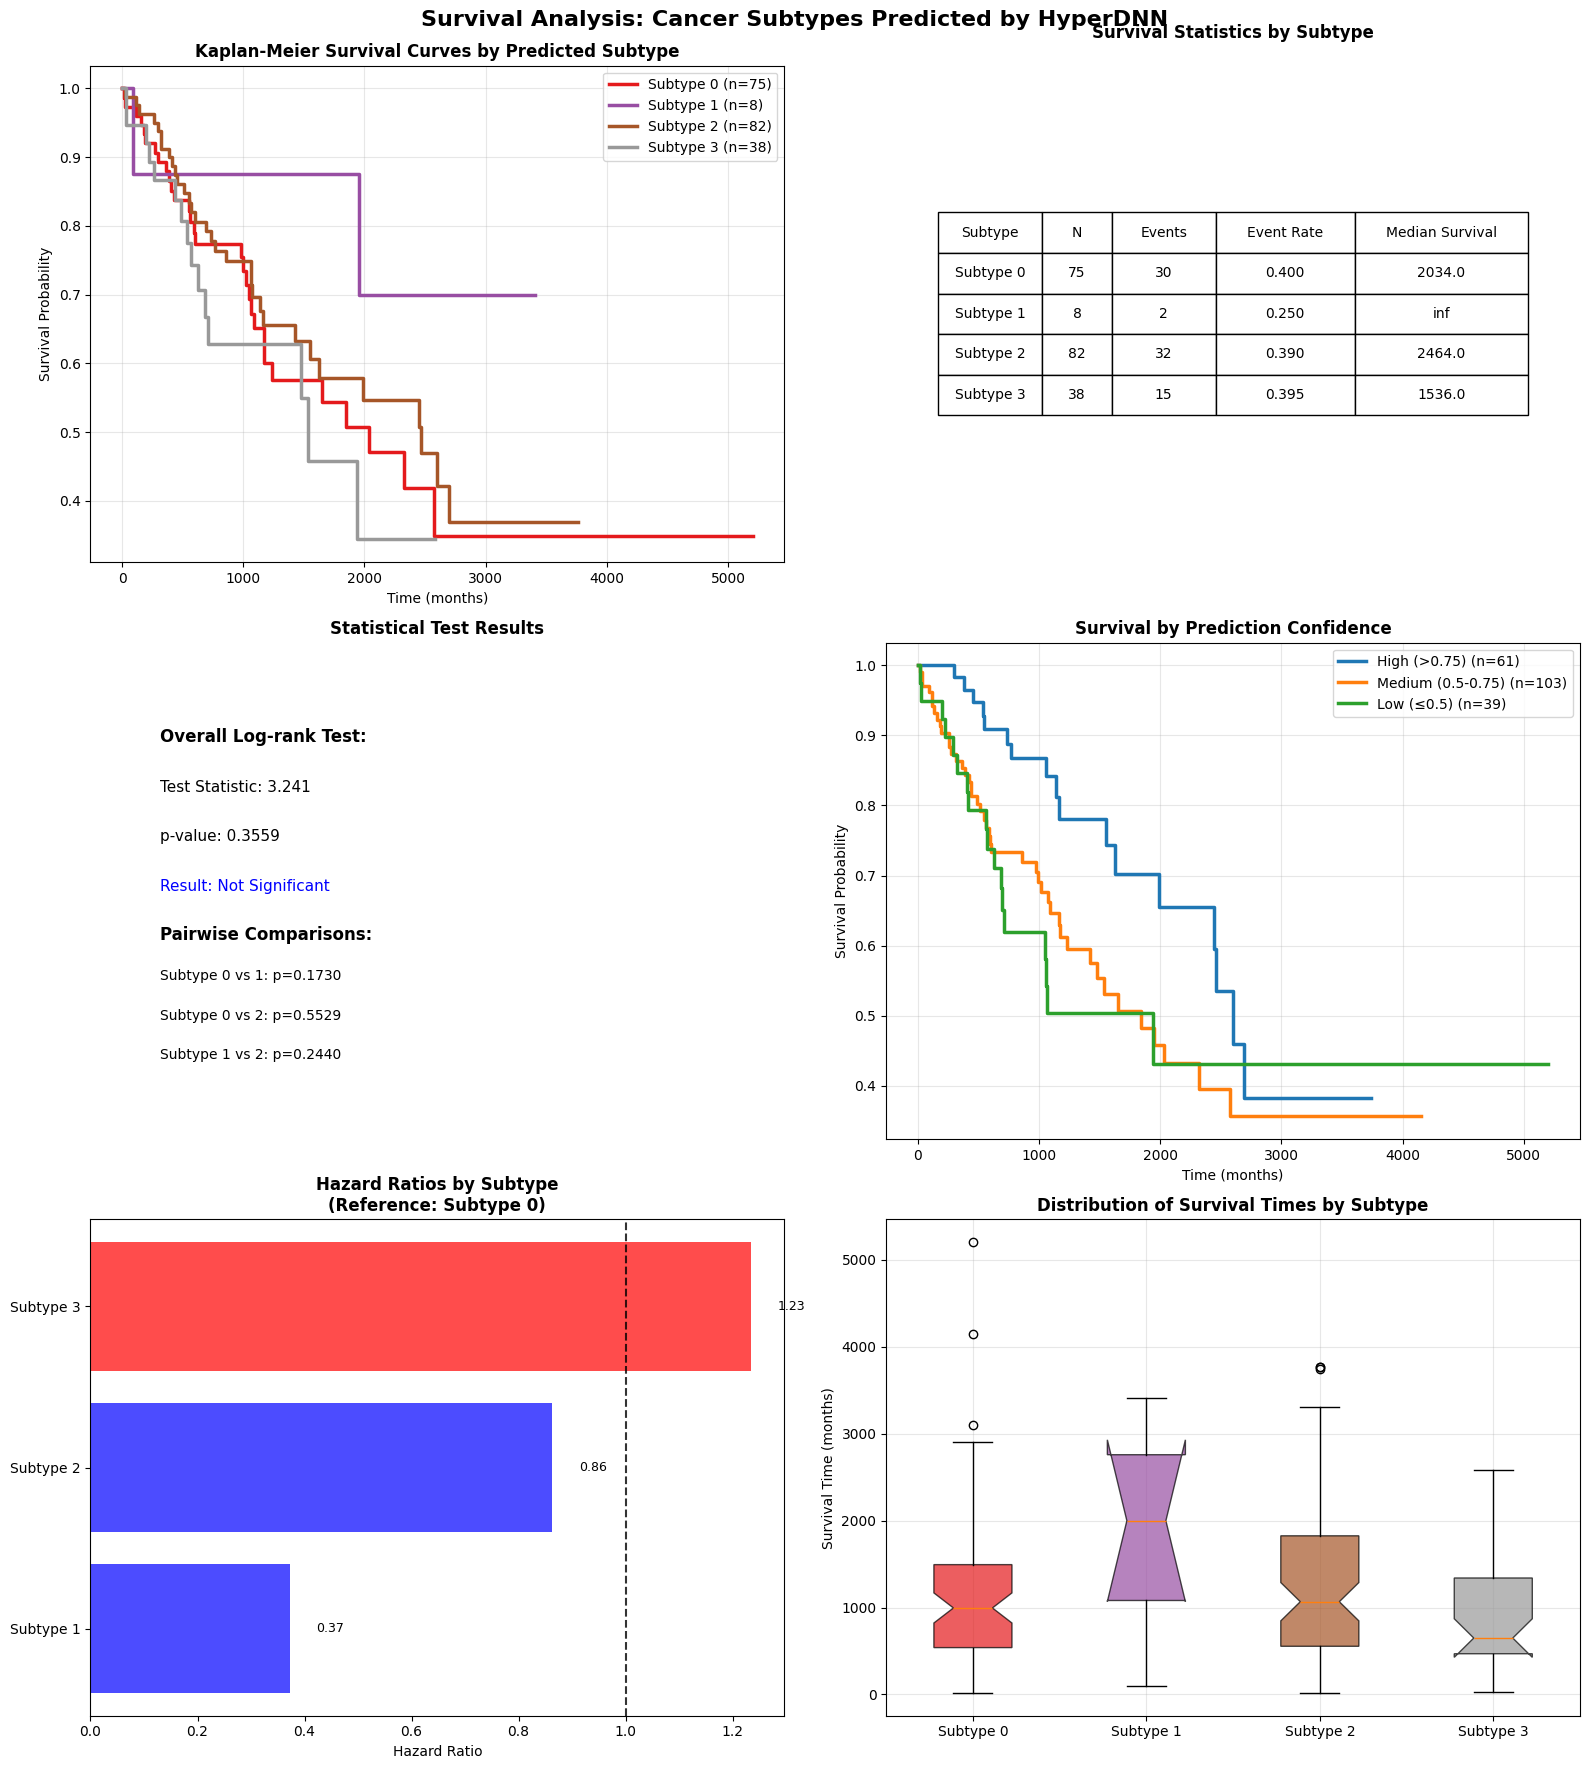


SURVIVAL ANALYSIS SUMMARY (HyperDNN)
Total patients with survival data: 203
Number of predicted subtypes: 4
Overall event rate (deaths): 0.389
Median follow-up time: 995.0 months


In [24]:
# Comprehensive Survival Analysis Visualization
if len(survival_analysis_df) > 0:
    # Create a comprehensive survival analysis visualization
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Survival Analysis: Cancer Subtypes Predicted by HyperDNN', 
                 fontsize=16, fontweight='bold')
    
    # Color palette for subtypes
    n_subtypes = len(survival_analysis_df['predicted_subtype'].unique())
    colors = plt.cm.Set1(np.linspace(0, 1, n_subtypes))
    subtype_colors = {subtype: colors[i] for i, subtype in enumerate(sorted(survival_analysis_df['predicted_subtype'].unique()))}
    
    # 1. Kaplan-Meier Survival Curves by Predicted Subtype
    kmf = KaplanMeierFitter()
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'], 
                label=f'Subtype {subtype} (n={len(subtype_data)})')
        kmf.plot_survival_function(ax=axes[0, 0], color=subtype_colors[subtype], 
                                 linewidth=2.5, ci_show=False)
    
    axes[0, 0].set_title('Kaplan-Meier Survival Curves by Predicted Subtype', fontweight='bold')
    axes[0, 0].set_xlabel('Time (months)')
    axes[0, 0].set_ylabel('Survival Probability')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend(loc='best')
    
    # 2. Survival Statistics Summary
    axes[0, 1].axis('off')
    survival_stats = []
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'])
        
        median_survival = kmf.median_survival_time_
        event_rate = subtype_data['OS'].mean()
        n_patients = len(subtype_data)
        
        survival_stats.append({
            'Subtype': f'Subtype {subtype}',
            'N': n_patients,
            'Events': int(subtype_data['OS'].sum()),
            'Event Rate': f'{event_rate:.3f}',
            'Median Survival': f'{median_survival:.1f}' if not np.isnan(median_survival) else 'Not reached'
        })
    
    stats_df = pd.DataFrame(survival_stats)
    table = axes[0, 1].table(cellText=stats_df.values,
                            colLabels=stats_df.columns,
                            cellLoc='center',
                            loc='center',
                            colWidths=[0.15, 0.1, 0.15, 0.2, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    axes[0, 1].set_title('Survival Statistics by Subtype', fontweight='bold', pad=20)
    
    # 3. Log-rank Test Results
    try:
        # Perform pairwise log-rank tests
        subtypes = sorted(survival_analysis_df['predicted_subtype'].unique())
        if len(subtypes) > 1:
            # Overall log-rank test
            results = multivariate_logrank_test(
                survival_analysis_df['OS.time'],
                survival_analysis_df['predicted_subtype'],
                survival_analysis_df['OS']
            )
            
            axes[1, 0].axis('off')
            axes[1, 0].text(0.1, 0.8, f'Overall Log-rank Test:', fontweight='bold', fontsize=12)
            axes[1, 0].text(0.1, 0.7, f'Test Statistic: {results.test_statistic:.3f}', fontsize=11)
            axes[1, 0].text(0.1, 0.6, f'p-value: {results.p_value:.4f}', fontsize=11)
            significance = "Significant" if results.p_value < 0.05 else "Not Significant"
            axes[1, 0].text(0.1, 0.5, f'Result: {significance}', fontsize=11, 
                           color='red' if results.p_value < 0.05 else 'blue')
            axes[1, 0].set_title('Statistical Test Results', fontweight='bold')
            
            # Pairwise comparisons for first few subtypes
            pairwise_results = []
            for i in range(min(3, len(subtypes))):
                for j in range(i+1, min(3, len(subtypes))):
                    subtype_i_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtypes[i]]
                    subtype_j_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtypes[j]]
                    
                    if len(subtype_i_data) > 5 and len(subtype_j_data) > 5:  # Minimum sample size
                        lr_result = logrank_test(
                            subtype_i_data['OS.time'], subtype_j_data['OS.time'],
                            subtype_i_data['OS'], subtype_j_data['OS']
                        )
                        pairwise_results.append({
                            'Comparison': f'Subtype {subtypes[i]} vs {subtypes[j]}',
                            'Test Statistic': f'{lr_result.test_statistic:.3f}',
                            'p-value': f'{lr_result.p_value:.4f}',
                            'Significant': 'Yes' if lr_result.p_value < 0.05 else 'No'
                        })
            
            if pairwise_results:
                y_pos = 0.4
                axes[1, 0].text(0.1, y_pos, 'Pairwise Comparisons:', fontweight='bold', fontsize=12)
                for idx, result in enumerate(pairwise_results):
                    y_pos -= 0.08
                    axes[1, 0].text(0.1, y_pos, f"{result['Comparison']}: p={result['p-value']}", fontsize=10)
    
    except Exception as e:
        axes[1, 0].text(0.1, 0.5, f'Statistical test error: {str(e)}', fontsize=10)
        axes[1, 0].set_title('Statistical Test Results', fontweight='bold')
    
    # 4. Survival by Prediction Confidence
    # Create confidence groups based on max probability
    survival_analysis_df['confidence_group'] = pd.cut(
        survival_analysis_df['max_prob'], 
        bins=[0, 0.5, 0.75, 1.0], 
        labels=['Low (≤0.5)', 'Medium (0.5-0.75)', 'High (>0.75)']
    )
    
    for conf_group in survival_analysis_df['confidence_group'].dropna().unique():
        group_data = survival_analysis_df[survival_analysis_df['confidence_group'] == conf_group]
        if len(group_data) > 2:
            kmf.fit(group_data['OS.time'], group_data['OS'], label=f'{conf_group} (n={len(group_data)})')
            kmf.plot_survival_function(ax=axes[1, 1], linewidth=2.5, ci_show=False)
    
    axes[1, 1].set_title('Survival by Prediction Confidence', fontweight='bold')
    axes[1, 1].set_xlabel('Time (months)')
    axes[1, 1].set_ylabel('Survival Probability')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend(loc='best')
    
    # 5. Hazard Ratios (Cox Proportional Hazards Model)
    try:
        # Prepare data for Cox regression
        cox_data = survival_analysis_df[['OS.time', 'OS', 'predicted_subtype']].copy()
        
        # Create dummy variables for subtypes (reference: subtype 0)
        subtype_dummies = pd.get_dummies(cox_data['predicted_subtype'], prefix='subtype')
        cox_data = pd.concat([cox_data, subtype_dummies], axis=1)
        
        # Remove reference category and original subtype column
        reference_col = f'subtype_{sorted(survival_analysis_df["predicted_subtype"].unique())[0]}'
        if reference_col in cox_data.columns:
            cox_data = cox_data.drop([reference_col, 'predicted_subtype'], axis=1)
        
        # Fit Cox model
        cph = CoxPHFitter()
        cph.fit(cox_data, duration_col='OS.time', event_col='OS')
        
        # Plot hazard ratios
        hazard_ratios = cph.summary[['coef', 'exp(coef)', 'p']]
        hazard_ratios.columns = ['Log HR', 'Hazard Ratio', 'p-value']
        
        # Create hazard ratio plot
        hr_values = hazard_ratios['Hazard Ratio'].values
        hr_labels = [col.replace('subtype_', 'Subtype ') for col in hazard_ratios.index]
        
        bars = axes[2, 0].barh(range(len(hr_values)), hr_values, 
                              color=['red' if hr > 1 else 'blue' for hr in hr_values],
                              alpha=0.7)
        axes[2, 0].axvline(x=1, color='black', linestyle='--', alpha=0.8)
        axes[2, 0].set_yticks(range(len(hr_labels)))
        axes[2, 0].set_yticklabels(hr_labels)
        axes[2, 0].set_xlabel('Hazard Ratio')
        axes[2, 0].set_title('Hazard Ratios by Subtype\n(Reference: Subtype 0)', fontweight='bold')
        
        # Add HR values on bars
        for i, (bar, hr, p_val) in enumerate(zip(bars, hr_values, hazard_ratios['p-value'])):
            significance = '*' if p_val < 0.05 else ''
            axes[2, 0].text(hr + 0.05, bar.get_y() + bar.get_height()/2, 
                           f'{hr:.2f}{significance}', va='center', fontsize=9)
        
    except Exception as e:
        axes[2, 0].text(0.5, 0.5, f'Cox regression error: {str(e)}', 
                       ha='center', va='center', transform=axes[2, 0].transAxes)
        axes[2, 0].set_title('Hazard Ratios by Subtype', fontweight='bold')
    
    # 6. Survival Distribution by Subtype (Box Plot)
    survival_times_by_subtype = []
    subtype_labels = []
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        survival_times_by_subtype.append(subtype_data['OS.time'].values)
        subtype_labels.append(f'Subtype {subtype}')
    
    box_plot = axes[2, 1].boxplot(survival_times_by_subtype, labels=subtype_labels, 
                                 patch_artist=True, notch=True)
    
    # Color the boxes
    for patch, color in zip(box_plot['boxes'], [subtype_colors[s] for s in sorted(survival_analysis_df['predicted_subtype'].unique())]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[2, 1].set_ylabel('Survival Time (months)')
    axes[2, 1].set_title('Distribution of Survival Times by Subtype', fontweight='bold')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("SURVIVAL ANALYSIS SUMMARY (HyperDNN)")
    print("="*80)
    print(f"Total patients with survival data: {len(survival_analysis_df)}")
    print(f"Number of predicted subtypes: {len(survival_analysis_df['predicted_subtype'].unique())}")
    print(f"Overall event rate (deaths): {survival_analysis_df['OS'].mean():.3f}")
    print(f"Median follow-up time: {survival_analysis_df['OS.time'].median():.1f} months")
    
else:
    print("Cannot perform survival analysis - no matching samples between survival and prediction data")